In [1]:
import pandas as pd
import os
import numpy as np
import glob
import gdal
from gdalconst import GA_ReadOnly

In [36]:
# rename the NDVI by week
ndvi_dir = "R:\\UnitedStates\\ForDRI_project-NEW\\Case_Study_2022_Growing_Season\\eMODIS_NDVI_V6\\"
for root, dirs, files in os.walk(ndvi_dir):
     for f in files:
        fdir = os.path.join(root,f)
        year = f.split('.')[1]
        ftype = f.split('.')[4]
        if ftype == "VI_NDVI" and f[-3:]=='tif':
            date = int(f.split('.')[2][-3:])
            print(date)
            week = date//7
            print(week)
            if week < 10:
                week_str = "0"+str(week)
            else:
                week_str = str(week)
            new_name = "NDVI_2022"+week_str+".tif"
            os.rename(fdir, ndvi_dir+new_name)
            print(f)

10
1
US_eMAH_NDVI.2022.004-010.1KM.VI_NDVI.006.2022016193402.tif
17
2
US_eMAH_NDVI.2022.011-017.1KM.VI_NDVI.006.2022020151132.tif
24
3
US_eMAH_NDVI.2022.018-024.1KM.VI_NDVI.006.2022034180606.tif
31
4
US_eMAH_NDVI.2022.025-031.1KM.VI_NDVI.006.2022034190031.tif
38
5
US_eMAH_NDVI.2022.032-038.1KM.VI_NDVI.006.2022041152005.tif
45
6
US_eMAH_NDVI.2022.039-045.1KM.VI_NDVI.006.2022054213103.tif
52
7
US_eMAH_NDVI.2022.046-052.1KM.VI_NDVI.006.2022056160021.tif


In [2]:
idir = "R:\\UnitedStates\\ForDRI_project-NEW\\Case_Study_2022_Growing_Season\\NDVI\\NDVI_prj\\"
ndvi_list = glob.glob(idir+"*.tif")
ndvi_list.sort()

In [3]:
maskDs = gdal.Open('R:\\UnitedStates\\ForDRI_project-NEW\\New_Model_2022\\INPUT_NEW_DATA_2022\\NDVI\\NDVI_200901.tif', GA_ReadOnly)# your mask raster
projection=maskDs.GetProjectionRef()
geoTransform = maskDs.GetGeoTransform()
minx = geoTransform[0]
maxy = geoTransform[3]
maxx = minx + geoTransform[1] * maskDs.RasterXSize
miny = maxy + geoTransform[5] * maskDs.RasterYSize

In [4]:
for f in ndvi_list:
    fname = os.path.basename(f)
    data=gdal.Open(f, GA_ReadOnly) #Your data the one you want to clip
    output = "R:\\UnitedStates\\ForDRI_project-NEW\\Case_Study_2022_Growing_Season\\NDVI\\masked\\"+fname #output file
    gdal.Translate(output,data,format='GTiff',projWin=[minx,maxy,maxx,miny],outputSRS=projection)

In [9]:
ndvi_list = glob.glob("R:\\UnitedStates\\ForDRI_project-NEW\\Case_Study_2022_Growing_Season\\NDVI\\masked\\"+"*.tif")
ndvi_list.sort()

In [11]:
driver = gdal.GetDriverByName("GTiff")
for f in ndvi_list:
    fname = os.path.basename(f)
    ds = gdal.Open(f)
    arr = ds.ReadAsArray().astype(np.float)
    arr[arr==32767] = np.nan
    arr[arr==-2000] = np.nan
    arr = 0.0001*arr
    # print(np.nanmin(arr),np.nanmax(arr))
    ndvi = driver.Create("R:\\UnitedStates\\ForDRI_project-NEW\\Case_Study_2022_Growing_Season\\NDVI\\" + fname, arr.shape[1], arr.shape[0], 1, gdal.GDT_Float32)
    ndvi.GetRasterBand(1).WriteArray(arr)
    ndvi.SetGeoTransform(geoTransform)
    ndvi.SetProjection(projection)
    ndvi.FlushCache()
    del ndvi

## old revises

In [5]:
#correct the missing value/ replace 202013
f = "E:\\New_ForDRI\\missing_NDVI\\NDVI_202012.tif"
output = "E:\\New_ForDRI\\missing_NDVI\\NDVI_202012_mask.tif" #output file
data=gdal.Open(f, GA_ReadOnly)
gdal.Translate(output,data,format='GTiff',projWin=[minx,maxy,maxx,miny],outputSRS=projection)


In [4]:
#correct the missing value/ replace 202013
driver = gdal.GetDriverByName("GTiff")
output = "E:\\New_ForDRI\\missing_NDVI\\NDVI_202012_mask.tif"
time = os.path.basename(output)[-10:-4]
ds = gdal.Open(output)
arr = ds.ReadAsArray().astype(np.float)
arr[arr==32767] = np.nan
arr[arr==-2000] = np.nan
arr = 0.0001*arr
ndvi = driver.Create("R:\\UnitedStates\\ForDRI_project-NEW\\New_Model_2022\\NDVI\\NDVI_final\\eMODIS202012.tif", arr.shape[1], arr.shape[0], 1, gdal.GDT_Float32)
ndvi.GetRasterBand(1).WriteArray(arr)
ndvi.SetGeoTransform(geoTransform)
ndvi.SetProjection(projection)
ndvi.FlushCache()

## standardization

In [4]:
ndvi_list =  glob.glob("R:\\UnitedStates\\ForDRI_project-NEW\\New_Model_2022\\NDVI\\NDVI_final\\"+"*.tif")
ndvi_list.sort()

In [5]:
ndvi_arr = []
for ndvi in ndvi_list:
    ds = gdal.Open(ndvi)
    arr = ds.ReadAsArray()
    arr[arr<-2] = np.nan
    ndvi_arr.append(arr)
ndvi_arr = np.asarray(ndvi_arr)

In [ ]:
idir = "R:\\UnitedStates\\ForDRI_project-NEW\\New_Model_2022\\NDVI\\"
driver = gdal.GetDriverByName("GTiff")
for i in range(1,53):
    if i < 10:
        week = '0'+str(i)
    else:
        week = str(i)
    ndvi_month = ndvi_arr[i-1::52,:,:]
    ndvi_mean = np.mean(ndvi_month,0)
    mean = driver.Create(idir+'NDVI_MEAN\\MEAN_' + week +'.tif', ndvi_mean.shape[1], ndvi_mean.shape[0], 1, gdal.GDT_Float32)
    mean.GetRasterBand(1).WriteArray(ndvi_mean)
    ndvi_std = np.std(ndvi_month,0)
    std = driver.Create(idir+'NDVI_STD\\STD_' + week +'.tif', ndvi_std.shape[1], ndvi_std.shape[0], 1, gdal.GDT_Float32)
    std.GetRasterBand(1).WriteArray(ndvi_std)
    print(week)
    mean.FlushCache()
    std.FlushCache()
    mean.SetGeoTransform(geoTransform)
    mean.SetProjection(projection)
    std.SetGeoTransform(geoTransform)
    std.SetProjection(projection)
    del mean, std

In [29]:
ndvi_list = glob.glob('R:\\UnitedStates\\ForDRI_project-NEW\\Case_Study_2022_Growing_Season\\NDVI\\' + '*.tif')
ndvi_list.sort()
mean_list = glob.glob('R:\\UnitedStates\\ForDRI_project-NEW\\New_Model_2022\\Processing\\NDVI\\NDVI_MEAN\\' + '*.tif')
mean_list.sort()
std_list = glob.glob('R:\\UnitedStates\\ForDRI_project-NEW\\New_Model_2022\\Processing\\NDVI\\NDVI_STD\\' + '*.tif')
std_list.sort()

In [46]:
driver = gdal.GetDriverByName("GTiff")
for i in range(38):
    if i+1 < 10:
        week = '0'+str(i+1)
    else:
        week = str(i+1)
    # print(week)
    if week in ['13','14','15']:
        continue
    else:
        if i<13:
            ndvi = gdal.Open(ndvi_list[i])
            # print(ndvi_list[i])
        else:
            ndvi = gdal.Open(ndvi_list[i-3])
            # print(ndvi_list[i-3])
        ndvi_mean_arr = gdal.Open(mean_list[i]).ReadAsArray()
        ndvi_std_arr = gdal.Open(std_list[i]).ReadAsArray()
        # print(mean_list[i])
        ndvi_arr = ndvi.ReadAsArray()
        projection = ndvi.GetProjectionRef()
        geoTransform = ndvi.GetGeoTransform()
        stdNDVI = (ndvi_arr-ndvi_mean_arr)/ndvi_std_arr
        # stdNDVI[stdNDVI<-5] = np.nan
        # stdNDVI[stdNDVI>5] = np.nan # removing outliers
        zscore = driver.Create('R:\\UnitedStates\\ForDRI_project-NEW\\Case_Study_2022_Growing_Season\\stdNDVI\\NDVI_2022' +week+'.tif', stdNDVI.shape[1], stdNDVI.shape[0], 1, gdal.GDT_Float32)
        zscore.GetRasterBand(1).WriteArray(stdNDVI)
        zscore.GetRasterBand(1).SetNoDataValue(np.nan)
        zscore.SetGeoTransform(geoTransform)
        zscore.SetProjection(projection)
        zscore.FlushCache()
        print('NDVI_2022' +week)
        del zscore

NDVI_202201
NDVI_202202
NDVI_202203
NDVI_202204
NDVI_202205
NDVI_202206
NDVI_202207
NDVI_202208
NDVI_202209
NDVI_202210
NDVI_202211
NDVI_202212
NDVI_202216
NDVI_202217
NDVI_202218
NDVI_202219
NDVI_202220
NDVI_202221
NDVI_202222
NDVI_202223
NDVI_202224
NDVI_202225
NDVI_202226
NDVI_202227
NDVI_202228
NDVI_202229
NDVI_202230
NDVI_202231
NDVI_202232
NDVI_202233
NDVI_202234
NDVI_202235
NDVI_202236
NDVI_202237
NDVI_202238


In [39]:
np.nanmax(stdNDVI)

4.979766

## Check NDVI/stdNDVI in 2022

202201


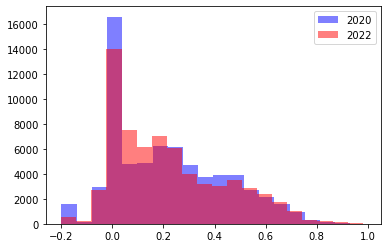

202202


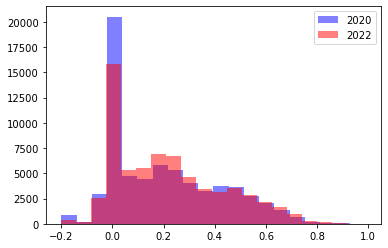

202203


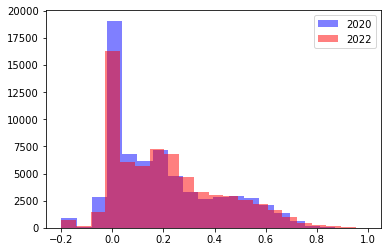

202204


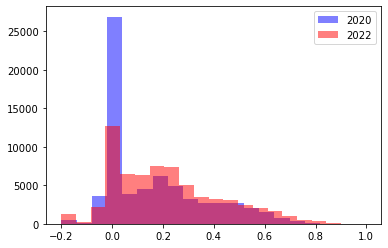

202205


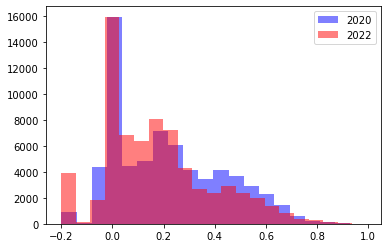

202206


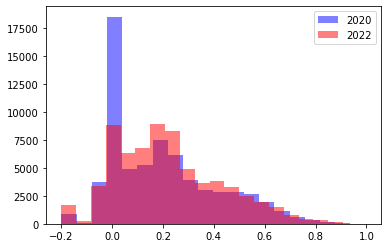

202207


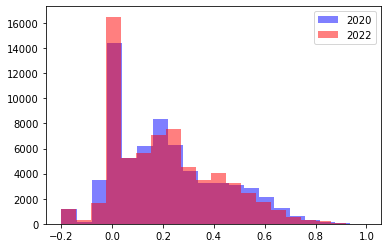

202208


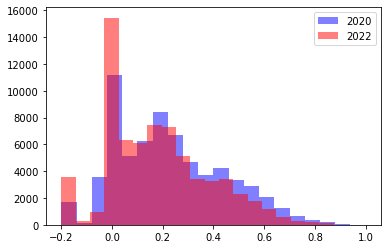

202209


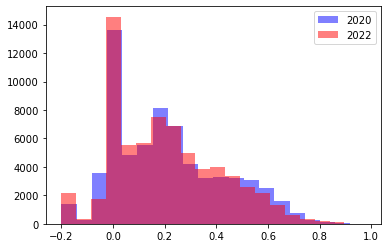

202210


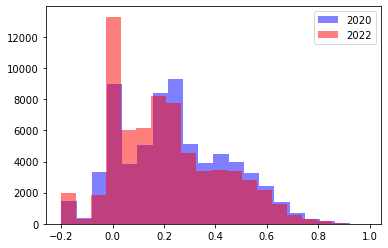

In [45]:
import matplotlib.pyplot as plt

ndvi_2022_dir = "R:\\UnitedStates\\ForDRI_project-NEW\\Case_Study_2022_Growing_Season\\NDVI\\"
ndvi_2022_list = glob.glob(ndvi_2022_dir+"*.tif")
ndvi_2022_list.sort()
ndvi_2020_dir = "R:\\UnitedStates\\ForDRI_project-NEW\\New_Model_2022\\Processing\\NDVI\\NDVI_all_orignal_values\\"
ndvi_2020_list = glob.glob(ndvi_2020_dir+"*.tif")
ndvi_2020_list.sort()
ndvi_mean_dir = "R:\\UnitedStates\\ForDRI_project-NEW\\New_Model_2022\\Processing\\NDVI\\NDVI_MEAN\\"
ndvi_mean_list = glob.glob(ndvi_mean_dir+"*.tif")
ndvi_mean_list.sort()
for i in range(10):
    ndvi_2020 = ndvi_2020_list[-52+i]
    #ndvi_2020_name = os.path.basename(ndvi_2020)
    #print(ndvi_2020[-10:-4])
    ndvi_2020_arr = gdal.Open(ndvi_2020).ReadAsArray()
    ndvi_2022 = ndvi_2022_list[i]
    ndvi_2022_name = os.path.basename(ndvi_2022)
    print(ndvi_2022[-10:-4])
    ndvi_2022_arr = gdal.Open(ndvi_2022).ReadAsArray()
    ndvi_mean = ndvi_mean_list[i]
    ndvi_mean_arr = gdal.Open(ndvi_mean).ReadAsArray()
    plt.figure()
    plt.hist(ndvi_2020_arr.flatten(),bins=20,color="blue",alpha=0.5,label="2020")
    plt.hist(ndvi_2022_arr.flatten(),bins=20,color="red",alpha=0.5,label='2022')
    #plt.hist(ndvi_mean_arr.flatten(),bins=20,color="grey",alpha=0.5,label='Mean')
    plt.legend()
    plt.show()

202201
-4.4037023 4.4444475


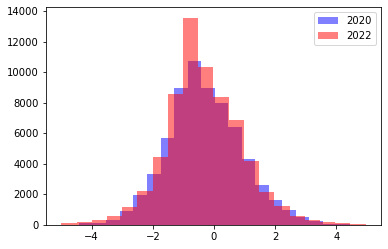

202202
-4.4445953 4.4392133


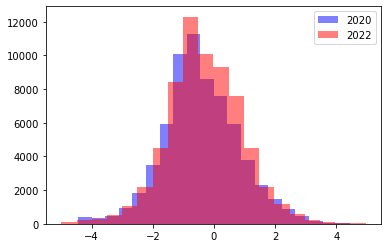

202203
-4.4200597 4.412498


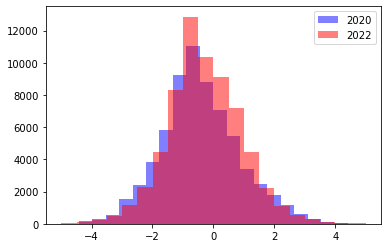

202204
-4.4528503 4.3626757


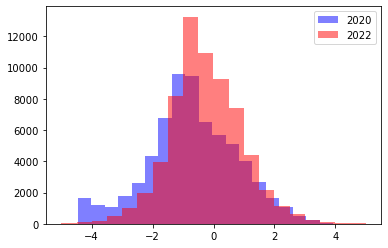

202205
-4.420845 4.381154


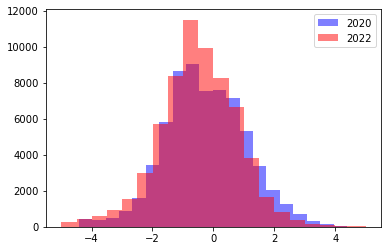

202206
-4.44095 4.3621216


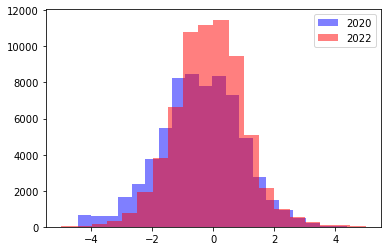

202207
-4.4214067 4.409436


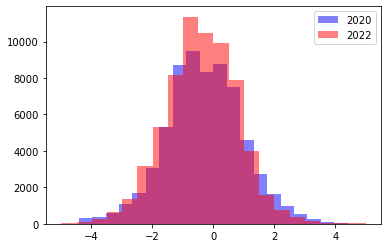

202208
-4.4134293 4.447006


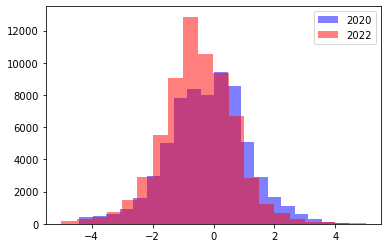

202209
-4.4361444 4.398682


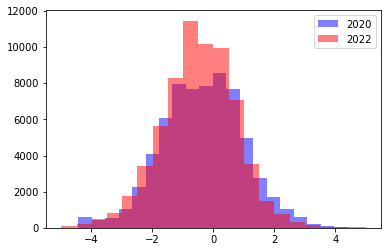

202210
-4.432554 4.4023013


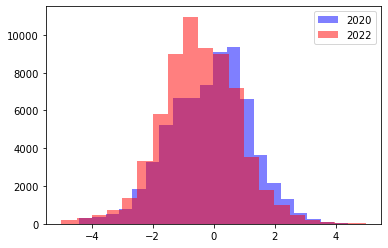

In [43]:
ndvi_2022_dir = "R:\\UnitedStates\\ForDRI_project-NEW\\Case_Study_2022_Growing_Season\\stdNDVI\\"
ndvi_2022_list = glob.glob(ndvi_2022_dir+"*.tif")
ndvi_2022_list.sort()
ndvi_2020_dir = "R:\\UnitedStates\\ForDRI_project-NEW\\New_Model_2022\\Processing\\NDVI\\NDVI_all_zscored\\"
ndvi_2020_list = glob.glob(ndvi_2020_dir+"*.tif")
ndvi_2020_list.sort()
ndvi_mean_dir = "R:\\UnitedStates\\ForDRI_project-NEW\\New_Model_2022\\Processing\\NDVI\\NDVI_MEAN\\"
ndvi_mean_list = glob.glob(ndvi_mean_dir+"*.tif")
ndvi_mean_list.sort()
for i in range(10):
    ndvi_2020 = ndvi_2020_list[-52+i]
    #ndvi_2020_name = os.path.basename(ndvi_2020)
    #print(ndvi_2020[-10:-4])
    ndvi_2020_arr = gdal.Open(ndvi_2020).ReadAsArray()
    ndvi_2022 = ndvi_2022_list[i]
    ndvi_2022_name = os.path.basename(ndvi_2022)
    print(ndvi_2022[-10:-4])
    ndvi_2022_arr = gdal.Open(ndvi_2022).ReadAsArray()
    ndvi_mean = ndvi_mean_list[i]
    ndvi_mean_arr = gdal.Open(ndvi_mean).ReadAsArray()
    print(np.nanmin(ndvi_2020_arr),np.nanmax(ndvi_2020_arr))
    plt.figure()
    plt.hist(ndvi_2020_arr.flatten(),bins=20,color="blue",alpha=0.5,label="2020")
    plt.hist(ndvi_2022_arr.flatten(),bins=20,color="red",alpha=0.5,label='2022')
    #plt.hist(ndvi_mean_arr.flatten(),bins=20,color="grey",alpha=0.5,label='Mean')
    plt.legend()
    plt.show()

In [90]:
ndvi38 = gdal.Open("R:\\UnitedStates\\ForDRI_project-NEW\\New_Model_2022\\Processing\\NDVI\\NDVI_all_zscored\\NDVI_202038.tif").ReadAsArray()

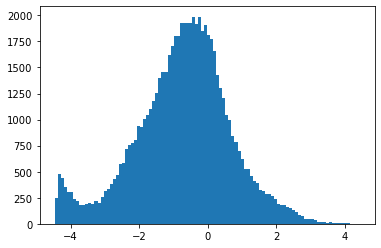

In [91]:
plt.hist(ndvi38.flatten(),bins=100)
plt.show()